# 📥 Øving 3

I denne øvingen skal du jobbe med å lese og bruke romlige data ved hjelp av GeoPandas.

Øvingsoppgaven finner du på Canvas under Oppgaver, eller på [dette GitHub-repoet](https://github.com/GMGI221-2024/gmgi221-ovinger).

Last den ned, åpne den i Jupyter Notebooks/Lab eller den editoren du bruker og følg instruksjonene i Notebooken. Lever den så inn på Canvas etter du har endret navn til "oving3-ditt_navn.ipynb".

## Tips til oppgaven:

### Pandas `apply()`-metoden:

Pandas' DataFrames har en metode `apply()` som kjører en brukerdefinert funksjon på hver rad eller på hver kolonne (avhengig av `axis`-parameteren, hvis `axis=1`, fungerer `apply()` på rader).

Resultatene av å kjøre funksjonen gjentatte ganger (parallelt, for å være presis) samles i en pandas.GeoSeries som er returverdien av `apply()` og kan tilordnes til en ny kolonne eller rad.

For eksempel kan dette brukes for å lage punkt-geometrier:

```python
def create_point(row):
    """Create a Point geometry from a row with x and y values."""
    point = shapely.geometry.Point(row["x"], row["y"])
    return point

point_series = data.apply(create_point, axis=1)
```

#### Bruke en anonym `lambda`-funksjon med `apply()`

Til slutt, for enkle funksjoner som passer på en enkelt linje, kan vi sende funksjonen inn i såkalt 'lambda-notasjon'. Lambda-funksjoner følger syntaksen `lambda argumenter: returverdi`, dvs. nøkkelordet `lambda` etterfulgt av ett eller flere, kommaseparerte argumentnavn (inputvariabler), et kolon (:), og returverdi-setningen (f.eks. en beregning). En lambda-funksjon som aksepterer to argumenter og returnerer summen av dem, vil se slik ut: `lambda a, b: (a + b)`.

Lambda-funksjoner kan bare brukes der de er definert, men tilbyr en praktisk snarvei for å slippe separate funksjoner for enkle uttrykk. De er svært vanlige i datavitenskapsprosjekter, men bør ikke brukes for mye: som en tommelfingerregel, ikke bruk lambda-funksjoner hvis koden deres ikke passer på en (kort) linje.

Les mer om lambda-funksjoner i [Python-dokumentasjonen](https://docs.python.org/3/tutorial/controlflow.html#lambda-expressions)

### Konvertere en `pandas.DataFrame` til en `geopandas.GeoDataFrame`

Noen ganger jobber vi med data som er i et ikke-romlig format (som Excel
eller CSV-regneark) men inneholder informasjon om plasseringen av poster, for
eksempel, i kolonner for lengde- og breddegradverdier. Mens geopandas sin
`read_file()`-funksjon kan lese noen formater, er det ofte tryggest å bruke
pandas for å lese datasettet og deretter konvertere det til en `GeoDataFrame`.

La oss anta at vi leser følgende tabell ved å bruke `pandas.read_csv()` inn i en
variabel `df`:

In [3]:
# sample data
import pandas
df = pandas.DataFrame({
    "longitude": [24.9557, 24.8353, 24.9587],
    "latitude": [60.1555, 60.1878, 60.2029]
})

In [4]:
df

,longitude,latitude
0,24.9557,60.1555
1,24.8353,60.1878
2,24.9587,60.2029


`geopandas.GeoDataFrame()`-konstruktøren aksepterer en `pandas.DataFrame` som input, men den fyller ikke automatisk `geometry`-kolonnen. Biblioteket kommer imidlertid med en praktisk hjelpefunksjon `geopandas.points_from_xy()`. Som vi alle vet, bør et romlig datasett alltid ha et koordinatreferansesystem (CRS) definert; vi kan spesifisere CRS for inngangsdataene her også:

In [5]:
import geopandas

gdf = geopandas.GeoDataFrame(
    df,
    geometry=geopandas.points_from_xy(df.longitude, df.latitude),
    crs="EPSG:4326"
)

gdf

,longitude,latitude,geometry
0,24.9557,60.1555,POINT (24.95570 60.15550)
1,24.8353,60.1878,POINT (24.83530 60.18780)
2,24.9587,60.2029,POINT (24.95870 60.20290)


Nå har vi en 'ordentlig' `GeoDataFrame` som vi kan utføre alle romlige operasjoner vi ønsker med.

### Opprette en ny `geopandas.GeoDataFrame`: alternativ 1

Noen ganger gir det mening å starte fra bunnen av med et tomt datasett og gradvis legge til poster. Selvfølgelig er dette også mulig med geopandas' dataframes, som deretter kan lagres som en ny geopackage eller shapefil.

Først, opprett en helt tom `GeoDataFrame`:

In [21]:
import geopandas

new_geodataframe = geopandas.GeoDataFrame()

Deretter, opprett shapely-geometriobjekter og legg dem inn i dataframen. For å legge inn et geometriobjekt i `geometry`-kolonnen, og et navn i `name`-kolonnen, i en ny rad, bruk:

In [22]:
import shapely.geometry
polygon = shapely.geometry.Polygon(
    [
        (10.744868,59.913090),
        (10.744548,59.912731),
        (10.745796,59.912435),
        (10.746048,59.912704)
    ]
)
name = "Stortorget"

new_geodataframe.loc[
    len(new_geodataframe),  # in which row,
    ["name", "geometry"]    # in which columns to save values
] = [name, polygon]

new_geodataframe

,name,geometry
0,Stortorget,"POLYGON ((10.74487 59.91309, 10.74455 59.91273..."


Før du lagrer det nyopprettede datasettet, ikke glem å definere et kartografisk referansesystem for det. Ellers vil du få problemer med å gjenbruke filen i andre programmer:

<Axes: >

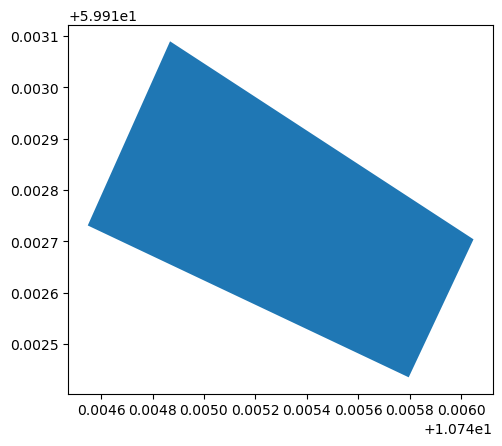

In [23]:
new_geodataframe = new_geodataframe.set_geometry("geometry")
new_geodataframe.crs = "EPSG:4326"

:::{hint}
I eksempelet ovenfor brukte vi `len(new_geodataframe)` som en radindeks
(som, i en nyopprettet dataframe, er ekvivalent med radnummeret). Siden
rader telles fra 0, er antall rader (lengden på dataframen) en større enn adressen til den siste raden. Dette uttrykket legger derfor alltid til en ny rad, uavhengig av den faktiske lengden på dataframen.

Merk at, strengt tatt, er indeksen uavhengig av radnummeret,
men i nyopprettede dataframes er de identiske.
:::

### Opprette en ny `geopandas.GeoDataFrame`: alternativ 2

Ofte er det mer praktisk og mer elegant å først opprette en ordbok (dictionary)
for å samle data, som deretter kan konverteres til en dataframe på en gang.

For dette, definer først en `dict` med kolonnenavnene som nøkler, og tomme `list`er
som verdier:


In [24]:
data = {
    "name": [],
    "geometry": []
}

Deretter fyller du ordboken med data:

In [25]:
import shapely.geometry

data["name"].append("Stortorget")
data["geometry"].append(
    shapely.geometry.Polygon(
        [
            (10.744868,59.913090),
            (10.744548,59.912731),
            (10.745796,59.912435),
            (10.746048,59.912704)
        ]
    )
)

Til slutt, bruk denne ordboken som input for en ny `GeoDataFrame`. Ikke glem å spesifisere et CRS:

In [26]:
new_geodataframe = geopandas.GeoDataFrame(data, crs="EPSG:4326")
new_geodataframe

,name,geometry
0,Stortorget,"POLYGON ((10.74487 59.91309, 10.74455 59.91273..."


:::{note}
Disse to tilnærmingene resulterer i identiske `GeoDataFrame`s. Noen ganger er den ene teknikken mer praktisk enn den andre. Du bør alltid vurdere forskjellige måter å løse et problem på, og finne den mest passende og effektive løsningen (det finnes **alltid** mer enn én mulig løsning).
:::